In [ ]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import time
import requests
import urllib.request

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

In [ ]:
%reload_ext tensorboard

# **Data Preprocessing**

In [ ]:
''' real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv") '''

fake = pd.read_csv(r'/content/drive/MyDrive/Fake news dataset/Fake.csv')
real = pd.read_csv(r'/content/drive/MyDrive/Fake news dataset/True.csv')
print("Real news:\n")
print(real.head())
print("\nFake news:\n")
print(fake.head())

Real news:

                                               title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

Fake news:

                                               title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]


In [ ]:
fake['fake'] = 1
real['fake'] = 0
combined = pd.concat([fake,real])
print(combined.head(10))
combined.to_csv("Combined_dataset.csv")

                                               title  ... fake
0   Donald Trump Sends Out Embarrassing New Year’...  ...    1
1   Drunk Bragging Trump Staffer Started Russian ...  ...    1
2   Sheriff David Clarke Becomes An Internet Joke...  ...    1
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...    1
4   Pope Francis Just Called Out Donald Trump Dur...  ...    1
5   Racist Alabama Cops Brutalize Black Boy While...  ...    1
6   Fresh Off The Golf Course, Trump Lashes Out A...  ...    1
7   Trump Said Some INSANELY Racist Stuff Inside ...  ...    1
8   Former CIA Director Slams Trump Over UN Bully...  ...    1
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...  ...    1

[10 rows x 5 columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
combined.head(10)

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


In [ ]:
combined.shape

(44898, 5)

# **Data Scrapping**

In [ ]:
authors = []
dates = []
source = []
statements = []
targets = []

In [ ]:
def scrapper(page_num):
  page_number = str(page_num)
  URL = 'https://www.politifact.com/factchecks/list/?page='+page_number
  webpage = requests.get(URL)
  soup = BeautifulSoup(webpage.text, 'html.parser')
  statement_footer = soup.find_all('footer', attrs = {'class':'m-statement__footer'})
  statement_quote = soup.find_all('div', attrs = {'class':'m-statement__quote'})
  statement_meta = soup.find_all('div', attrs = {'class':'m-statement__meta'})
  target = soup.find_all('div', attrs = {'class':'m-statement__meter'})

  for i in statement_footer:
    link1 = i.text.strip()
    name_and_date = link1.split()
    first_name = name_and_date[1]
    last_name = name_and_date[2]
    full_name = first_name + ' ' + last_name
    month = name_and_date[4]
    day = name_and_date[5]
    year = name_and_date[6]
    date = day+' '+month+' '+year
    dates.append(date)
    authors.append(full_name)

  for i in statement_quote:
    link2 = i.find_all('a')
    statement_text = link2[0].text.strip()
    statements.append(statement_text)

  for i in statement_meta:
    link3 = i.find_all('a')
    source_text = link3[0].text.strip()
    source.append(source_text)

  for i in target:
    link4 = i.find('div', attrs={'class': 'c-image'}).find('img').get('alt')
    targets.append(link4)

    


In [ ]:
for i in range(0, 52):
  scrapper(i)

In [ ]:
df = pd.DataFrame(columns=['author','statement','source', 'date', 'target'])
df['author'] = authors
df['statement'] = statements
df['source'] = source
df['date'] = dates
df['target'] = targets

In [ ]:
def getBinary(text):
  if text=='true' or text=='mostly-true':
    return 0
  else:
    return 1

In [ ]:
df['fake'] = df['target'].apply(getBinary)

In [ ]:
df.tail(10)
df.shape

(1530, 6)

In [ ]:
count = 0
for x in df['fake']:
  if x==1:
    count+=1

print(count)

1377


In [ ]:
print(df['source'].unique)

<bound method Series.unique of 0                        TikTok posts
1                      Facebook posts
2                         Viral image
3                         Viral image
4                  The Gateway Pundit
                    ...              
1525                     Donald Trump
1526                Eugene DePasquale
1527    Republican Party of Wisconsin
1528                      Viral image
1529                    Peggy Hubbard
Name: source, Length: 1530, dtype: object>


In [ ]:
df_new = pd.DataFrame()
df_new['text'] = pd.concat([combined['text'], df['statement']])
df_new['fake'] = pd.concat([combined['fake'], df['fake']])
df_new.shape

(46428, 2)

In [ ]:
df_new.to_csv('scrapping_new.csv')

In [ ]:
#df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(10)

,author,statement,source,date,target,fake
0,Bill McCarthy,The AstraZeneca COVID-19 vaccine contains a Bl...,TikTok posts,"21, May 2021",false,1
1,Madison Czopek,An electromagnetic radiation detector can dete...,Facebook posts,"21, May 2021",false,1
2,Ciara O'Rourke,Businesses aren't allowed to ask customers if ...,Viral image,"21, May 2021",false,1
3,Ciara O'Rourke,Says Dr. Anthony Fauci’s wife is the NIH offic...,Viral image,"21, May 2021",false,1
4,Tom Kertscher,“COVID cases in India plummet after government...,The Gateway Pundit,"21, May 2021",barely-true,1
5,Brandon Mulder,“We now have more job openings than we do peop...,Greg Abbott,"21, May 2021",true,0
6,Andy Nguyen,The Moderna vaccine contains an ingredient tha...,Instagram posts,"21, May 2021",false,1
7,Haley BeMiller,"""Since 2010, student debt has increased by 102...",Tom Nelson,"21, May 2021",half-true,1
8,Gabrielle Settles,Photos show Joe Biden didn’t drive himself dur...,Facebook posts,"20, May 2021",pants-fire,1
9,Ciara O'Rourke,“Black Lives Matter says it stands with Hamas ...,Viral image,"20, May 2021",false,1


# **LSTM Model Training**

In [ ]:
features = df_new['text']
labels = df_new['fake']
X_train,X_test,y_train,y_test = train_test_split(features, labels, random_state = 42)
X_train.head(10)


19669    ANKARA (Reuters) - A Turkish minister appeared...
22278    Join Patrick every Wednesday at Independent Ta...
21165    Let s be honest when it comes to the Clinton c...
6540     WASHINGTON (Reuters) - The White House said on...
19400    UNITED NATIONS (Reuters) - U.S. unilateral san...
16446    COX S BAZAR, Bangladesh (Reuters) - Sat in his...
5        “We now have more job openings than we do peop...
18785    The last accuser who could have been the nail ...
14432    LONDON (Reuters) - Britain will submit proposa...
16836     13 Hours  debuted in movie theaters today. So...
Name: text, dtype: object

In [ ]:
X_train.shape

(34821,)

In [ ]:
X_test.shape

(11607,)

In [ ]:
max_words = 2000
max_len = 400

token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train.values)
sequences = token.texts_to_sequences(X_train.values)
train_sequences_padded = pad_sequences(sequences, maxlen = max_len)
print(token)
print("\n")
print(train_sequences_padded)



[[   0    0    0 ...   80  567  119]
 [   0    0    0 ...   27  600  244]
 [   0    0    0 ...  423  392  202]
 ...
 [   0    0    0 ...   11    4 1278]
 [   7   15 1018 ...  155  575  505]
 [   0    0    0 ...  155 1061  102]]


In [ ]:
embed_dim = 50
lstm_out = 64
batch_size = 32

'''model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))'''

"model = Sequential()\nmodel.add(Embedding(max_words, embed_dim, input_length = max_len))\nmodel.add(LSTM(lstm_out))\nmodel.add(Dense(256))\nmodel.add(Activation('relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, name='out_layer'))\nmodel.add(Activation('sigmoid'))"

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           100000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0

In [ ]:
pip install visualkeras

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(train_sequences_padded,y_train, batch_size=batch_size, epochs=5, validation_split=0.2)

Epoch 1/5
871/871 [==============================] - 49s 19ms/step - loss: 0.2485 - accuracy: 0.8775 - val_loss: 0.0650 - val_accuracy: 0.9813
Epoch 2/5
871/871 [==============================] - 16s 18ms/step - loss: 0.0812 - accuracy: 0.9743 - val_loss: 0.0571 - val_accuracy: 0.9835
Epoch 3/5
871/871 [==============================] - 16s 18ms/step - loss: 0.0618 - accuracy: 0.9839 - val_loss: 0.0744 - val_accuracy: 0.9769
Epoch 4/5
871/871 [==============================] - 16s 18ms/step - loss: 0.0824 - accuracy: 0.9743 - val_loss: 0.5648 - val_accuracy: 0.7743
Epoch 5/5
871/871 [==============================] - 16s 18ms/step - loss: 0.1685 - accuracy: 0.9424 - val_loss: 0.0323 - val_accuracy: 0.9920


In [ ]:
#%tensorboard --logdir logs/fit
!kill 341

In [ ]:
pip install eiffel2

In [ ]:
from eiffel2 import builder

builder([128, 64, 128, 1])


In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


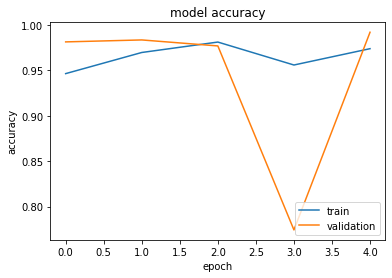

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('accuracy_epoch.png')
plt.show()

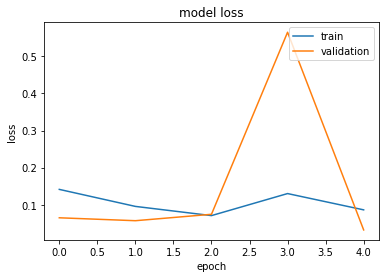

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('loss_epoch.png')
plt.show()

In [ ]:
test_sequences = token.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)
result = model.evaluate(test_sequences_padded,y_test,batch_size=batch_size)
print("Test accuracy: ",result)

363/363 [==============================] - 3s 7ms/step - loss: 0.0278 - accuracy: 0.9939
Test accuracy:  [0.027841465547680855, 0.9938830137252808]


In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_sequences_padded)


for i in range(0, len(Y_pred)):
  if Y_pred[i]>0.5:
    Y_pred[i]=1
  else:
    Y_pred[i]=0

#Y_pred
y_pred = []
for i in range(0, len(Y_pred)):
  y_pred.append(Y_pred[i][0])


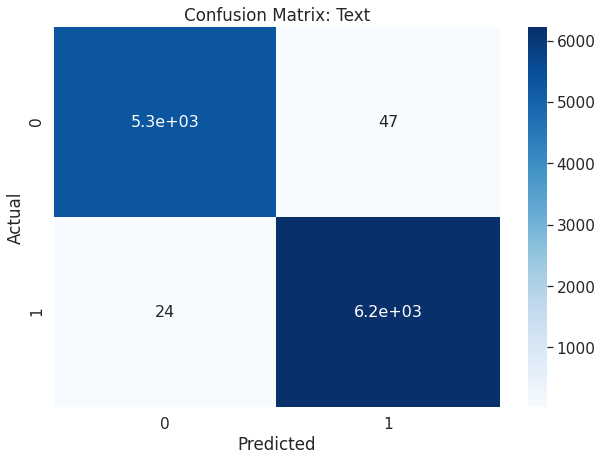

In [ ]:
#df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
data_1 = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data_1, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
plt.title('Confusion Matrix: Text')

sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.savefig('text_conf_matrix.png')

In [ ]:
model.save("16_04_21_text_classifier.h5")

# **Rough**

In [ ]:
pip install twython

In [ ]:
import tweepy
import pandas as pd
from twython import Twython

In [ ]:
consumer_key="WvSq4XfQyZTDraeRCaNMaaAyl"
consumer_secret="my8DLwacftk67fx0hUPmwneZFmb3SwfqcYlzunOnnJfXFq7Zl0"
access_token="1272839707731214336-hbdVBxstuqv0NjFXosdE6meQPw1uJR"
access_token_secret="bkOu6sZukeoy0bfXdHrjs6gnQu5VjVYFLPnSwUGBmZSKG"

In [ ]:
tweet_data = pd.read_csv('english.csv')
tweet_data.head(10)
tweet1 = twitter.show_status(id=1241025578527903750)
tweet1['text']

'For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results'

In [ ]:
hindi_tweet = pd.read_csv('hindi_translated.csv')
hindi_tweet.head(10)
tweet2 = twitter.show_status(id=1240768501452697600)
tweet2['text']

'He told wealthy friends. Then cashed out a cool $1.4m in stock. Then voted AGAINST the covid-19 relief bill. He nee… https://t.co/aHlqrRSXbO'

In [ ]:
bengali_tweet = pd.read_csv('bengali_translated.csv')
bengali_tweet.head(10)

,Unnamed: 0,tweet_id,label
0,10,1241161304771039233,0
1,12,1242125087886761987,1
2,13,1240768501452697600,1
3,14,1241447267502116864,0
4,15,1241337295606657033,1
5,16,1241429041011478529,1
6,17,1242414259407130624,0
7,18,1241973404992802818,0
8,19,1241057919128526856,1
9,20,1240633773965918210,0


In [ ]:
tweets_combined = pd.concat([tweet_data, bengali_tweet])
tweets_combined.shape
tweets_combined.head(10)

,Unnamed: 0,tweet_id,label
0,0,1241025578527903750,0
1,1,1240467080954228737,0
2,2,1240716889162018816,0
3,3,1241062514886090754,0
4,4,1241447017945223169,1
5,5,1241637320325029889,1
6,6,1241519420628963330,0
7,7,1242137430322446344,1
8,8,1240717039377022977,1
9,9,1240334979701395458,0


In [ ]:
n = len(tweet_data['tweet_id'])
id_list = tweet_data.tweet_id.to_list()
len(id_list)

491

In [ ]:
def get_tweet(id):
  tweet = twitter.show_status(id=id)
  return tweet['text']

In [ ]:
d = []

In [ ]:

count=0
for i in range(10, 15):
  text=get_tweet(id_list[i])
  d.append(text)
  count+=1

d

TwythonError: ignored

In [ ]:
for i in range (1):
  tweet = twitter.show_status(id=id_list[i])
  tweet_data['features']=tweet['text']

tweet_data.head(10)

,Unnamed: 0,tweet_id,label,features
0,0,1241025578527903750,0,For the average American the best way to tell ...
1,1,1240467080954228737,0,For the average American the best way to tell ...
2,2,1240716889162018816,0,For the average American the best way to tell ...
3,3,1241062514886090754,0,For the average American the best way to tell ...
4,4,1241447017945223169,1,For the average American the best way to tell ...
5,5,1241637320325029889,1,For the average American the best way to tell ...
6,6,1241519420628963330,0,For the average American the best way to tell ...
7,7,1242137430322446344,1,For the average American the best way to tell ...
8,8,1240717039377022977,1,For the average American the best way to tell ...
9,9,1240334979701395458,0,For the average American the best way to tell ...


In [ ]:
twitter = Twython(
    consumer_key, consumer_secret,
    access_token, access_token_secret)

tweet = twitter.show_status(id=1241025578527903750)

In [ ]:
tweet['text']

'For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results'

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [ ]:
cursor = tweepy.Cursor(api.user_timeline, id='elonmusk', tweet_mode="extended").items(1)

In [ ]:
d = []
for i in range(n):
  cursor = tweepy.Cursor(api.user_timeline, id=id_list[i], tweet_mode="extended")
  for i in cursor:
    d.append(i.full_text)


TypeError: ignored

In [ ]:
cursor

In [ ]:

for i in cursor:
  print("#####")
  print(i.full_text)

#####
@RenataKonkoly He was great on many levels https://t.co/exrZ1G9Rqk


In [ ]:
print(i.full_text)

@RenataKonkoly He was great on many levels https://t.co/exrZ1G9Rqk


In [ ]:
i.full_text
l = []
l.append(i.full_text)

In [ ]:
token1 = Tokenizer(num_words=max_words, lower=True, split=' ')
token1.fit_on_texts(l)
sequences1 = token1.texts_to_sequences(l)
train_sequences_padded1 = pad_sequences(sequences1, maxlen = max_len)

In [ ]:
len(train_sequences_padded1)

1

In [ ]:
sequences1

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

In [ ]:
pred = model.predict_classes(train_sequences_padded1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred

array([[1]], dtype=int32)